# LFADS
This notebook is part of the [SachsLab Workshop for Intracranial Neurophysiology and Deep Learning](https://github.com/SachsLab/IntracranialNeurophysDL).

Follow the link below to run in Google Colab or continue if running locally.

Run the first few cells to normalize Local / Colab environments, then proceed below for the lesson.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/06_01_LFADS.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/06_01_LFADS.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>


In [1]:
import os
import sys
from pathlib import Path
try:
    # See if we are running on google.colab
    import google.colab
    from google.colab import files
    if sys.version_info > (3, 0):
        from importlib import reload
        !pip install --upgrade -q https://storage.googleapis.com/jax-wheels/cuda$(echo $CUDA_VERSION | sed -e 's/\.//' -e 's/\..*//')/jaxlib-latest-cp36-none-linux_x86_64.whl
    else:
        !pip install --upgrade -q https://storage.googleapis.com/jax-wheels/cuda$(echo $CUDA_VERSION | sed -e 's/\.//' -e 's/\..*//')/jaxlib-latest-cp27-none-linux_x86_64.whl
    !pip install --upgrade -q git+https://github.com/google/jax.git

    os.chdir('..')
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        !pip install -q kaggle
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
    IN_COLAB = True
except ModuleNotFoundError:
    IN_COLAB = False
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')

In [2]:
# Download and unzip data (2.1 GB)
datadir = Path.cwd() / 'data' / 'joeyo'
if not (datadir / 'converted').is_dir():
    !kaggle datasets download --unzip --path {str(datadir / 'converted')} cboulay/joeyo_nhp_reach_mea
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")


Data directory found. Skipping download.


## Get LFADS code from google research repository

In [3]:
if not (Path.cwd() / '..' / 'ctd').is_dir():
    !git clone --recursive https://github.com/google-research/computation-thru-dynamics.git ../ctd
    !mv ../ctd/lfads_tutorial ./
import lfads_tutorial.lfads as lfads
import lfads_tutorial.plotting as plotting
import lfads_tutorial.utils as utils
from lfads_tutorial.optimize import optimize_lfads, get_kl_warmup_fun

## Imports


In [4]:
import jax.numpy as np
from jax import random
from jax.experimental import optimizers
#config.update("jax_debug_nans", True) # Useful for finding numerical errors
import matplotlib.pyplot as plt
import numpy as onp  # original CPU-backed NumPy
import time

## Randomization
> JAX uses its own setup to handle randomness and seeding the pseudo-random number generators.
You can read about it [here](https://github.com/google/jax/blob/master/README.md#random-numbers-are-different).


In [5]:
MAX_SEED_INT = 10000000
key = random.PRNGKey(onp.random.randint(0, MAX_SEED_INT))


## Get Data
Unlike notebook 05_02, where we used a small number of wide bins per sequence,
here we use a large number of narrow bins per sequence, where a sequence corresponds to an entire trial
from target onset to target hit (and a bit beyond for short trials).
### Data Hyperparameters


In [6]:
SESS_IDX = 7          # Index of recording session we will use. 0:8
MAX_TRIAL_DUR = 1.7   # This gets rid of about 5% of the slowest trials (long tail distribution)
BIN_DURATION = 0.020  # Width of window used to bin spikes, in seconds
P_TRAIN = 0.8         # Proportion of data used for training.


### Load Spiking Data
Mostly the same as previous notebooks, but now the data are segmented into trials from target onset to a common length capturing most of the trials.

In [7]:
from indl.lfads.data_helper import *
X, Y, X_ax_info, Y_ax_info, targ_times, targ_vecs = load_dat_with_vel_accel(datadir, SESS_IDX, trial_dur=MAX_TRIAL_DUR)
trial_X, trial_tvec, true_bin_dur = bin_and_segment_spike_times(X, X_ax_info, targ_times,
                                                                nearest_bin_dur=BIN_DURATION, trial_dur=MAX_TRIAL_DUR)

Keeping 463 of 487 trials (95.07186858316221 %) shorter than 1.7 s.
Actual bin duration: 0.02048


### Split Train and Validation


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_valid, targ_train, targ_valid = train_test_split(trial_X, targ_vecs.T, train_size=P_TRAIN)


### Visualize Data


trial_X has 463 trials, 83 bin-steps per trial, and 91 neurons.


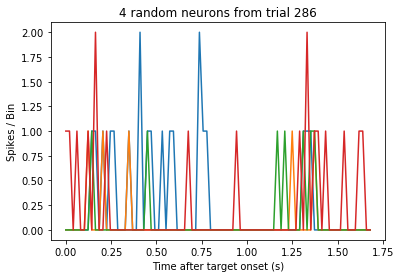

In [9]:
fig = plt.figure(facecolor='white')

n_trials, n_timesteps, n_neurons = trial_X.shape
print("trial_X has {} trials, {} bin-steps per trial, and {} neurons.".format(n_trials, n_timesteps, n_neurons))
trial_idx = onp.random.randint(0, n_trials-1, 1)[0]
neuron_idx = onp.random.randint(0, n_neurons-1, 4)
plt.plot(trial_tvec, trial_X[trial_idx, :, neuron_idx].T)
plt.title("{} random neurons from trial {}".format(len(neuron_idx), trial_idx))
plt.xlabel('Time after target onset (s)')
plt.ylabel('Spikes / Bin')

plt.show()


## LFADS - Latent Factor Analysis via Dynamical Systems
The rest of this notebook is based on a notebook and supporting code found in in the
[google-research/computation-thru-dynamics github repo](https://github.com/google-research/computation-thru-dynamics).

The LFADS model is summarized in the below diagram. For now we will ignore the bottom "Controller" and "Inferred inputs" parts.

![](https://raw.githubusercontent.com/google-research/computation-thru-dynamics/master/images/lfads_architecture_w_inferred_inputs_3.png)

The model is described in commented pseudocode below.

In [10]:
# Our data is of shape n_trials x n_bins_per_trial (aka timesteps) x n_neurons.
# The batched_data is a list of data of shape n_trials_per_batch x n_bins_per_trial x n_neurons
# Here we initialize it with an empty list just so we don't trigger errors when trying to run this cell.
batched_data = []

# For each batch of binned spike counts
for binned_spike_counts in batched_data:
    
    ##################
    ## ENCODER PART ##
    
    # Randomly drop out spikes. Re-randomized for each time-step!
    do_binned_spike_counts = Dropout(binned_spike_counts)
    
    # Run the data through a nonlinear recurrent **encoder**. They use a Bidirectional GRU layer.
    # n_neurons -> 2 * ENC_DIM
    _, enc_ends_fwd_last_bkwd_first = BidirectionalGRU(do_binned_spike_counts)
    # First return value is only used when calculating inferred inputs.
    
    # Convert the end-points of the RNN output to 'initial conditions', which is the per-trial mean and variance
    # to produce random vectors to encode the trial. This is the 'bottleneck' or 'latent variables' in a VAE.
    # 2 * ENC_DIM -> 2 * GEN_DIM; GEN_DIM for means and GEN_DIM for logvars
    ic_mean_logvar = Dense(Dropout(enc_ends_fwd_last_bkwd_first))
    
    ##################
    ## DECODER PART ##
    
    # The initial state used in the next step is a vector randomly drawn from the distribution calculated above.
    g = initial_state = diag_gaussian_sample(ic_mean_logvar)
    
    # The generator is a GRU that takes as input the initial state.
    # In the tensorflow implementation, this was a slightly specialized GRU: https://github.com/tensorflow/models/blob/c80de2ca3ec34c4d510961b6a604309772fc02ad/research/lfads/lfads.py#L158
    # The output is the RNN state timeseries.
    # 2 * GEN_DIM -> timesteps x GEN_DIM
    gen_states = []
    for step_ix in range(n_bins_per_trial):
        g = GRU(g, 0)
        g = Dropout(g)
        gen_states.append(g)
        
    # Normed linear transform the generator states into a time series of latent factors
    latent_factors = NormedLinear(gen_states)
        
    # The factors are transformed to give 'rates' for as many channels as there were neurons in the binned_spike_counts.
    reconstructed_log_rates = Dense(latent_factors)
    reconstructed_rates = exp(reconstructed_log_rates)
    
    ##########
    ## LOSS ##
    
    # The rates parameterize a Poisson distribution from which new spike trains are drawn.
    # And the new spike trains are compared to the input spike trains.
    log_p_xgz = mean(poisson_log_likelihood(binned_spike_counts, reconstructed_rates))
    # Combine with KL loss and L2 regularization.
    loss = -log_p_xgz + kl_loss() + l2_loss()
    
    ############
    ## UPDATE ##
    
    # All of the above would be wrapped in a compiled loss_fn called once per batch,
    # then we can use JAX grad to calculate the gradients of that function.
    gradients = grad(loss_fn)
        
    # Then the optimizer updates the model weights using the gradients.
    optimizer_update(gradients)
    

## LFADS Hyperparameters

In the above pseudocode the dimensions are mentioned but the hyperparameters are omitted.
There are many.

In [11]:
BATCH_SIZE = 16       # Number of trials in each training step during optimization
EPOCHS = 50           # Number of loops through the entire data set.

# LFADS architecture
ENC_DIM = 16          # Dim of hidden state in the encoder RNN.
CON_DIM = 2           # Dim of hidden state in the controller RNN.
II_DIM = 1            # Dim of latent variables in inferred inputs.
GEN_DIM = 32          # Dim of latent variables and generator RNN, should be large enough to generate dynamics
FACTORS_DIM = 8       # factors dim, should be large enough to capture most variance of dynamics

# Numerical stability
VAR_MIN = 0.001               # Minimal variance any gaussian can become.

# Initial state prior parameters
# the mean is set to zero in the code
IC_PRIOR_VAR = 0.1            # this is sigma^2 of uninformative prior

# Inferred input autoregressive prior parameters
ar_mean = 0.0                 # process mean
ar_autocorrelation_tau = 1.0  # seconds, how correlated each time point is
ar_noise_variance = 0.1       # noise variance

# Optimization Hyperparameters
num_batches = int(n_trials * EPOCHS / BATCH_SIZE)  # how many batches do we train
print_every = 20              # give information every so often

# Learning rate HPs
STEP_SIZE = 0.05              # initial learning rate
DECAY_FACTOR = 0.995          # learning rate decay param
DECAY_STEPS = 1               # learning rate decay param

# Regularization HPs
P_DROPOUT = 0.05              # Proportion of units to set to 0 on each step.
keep_rate = 1 - P_DROPOUT
L2_REG = 2.0e-5               # Parameter regularization strength.

# Numerical stability HPs
MAX_GRAD_NORM = 10.0          # gradient clipping above this value


### KL Warmup
From [LFADS tutorial optimize.py](https://github.com/google-research/computation-thru-dynamics/blob/master/lfads_tutorial/optimize.py):

> It turns out that the KL term can be a lot easier to optimize initially than learning how to
reconstruct your data. This results in a pathological stoppage of training where the KL goes to
nearly zero and training is broken there on out (as you cannot represent any a given trial from
uninformative priors). One way out of this is to warmup the KL penality, starting it off with a
weight term of 0 and then slowly building to 1, giving the reconstruction a chance to train a bit
without the KL penalty messing things up.


In [12]:
kl_warmup_start = 50.0 # batch number to start kl warmup, explicitly float
kl_warmup_end = 250.0  # batch number to be finished with kl warmup, explicitly float
kl_min = 0.01 # The minimum KL value, non-zero to make sure KL doesn't grow crazy before kicking in.
kl_max = 1.0


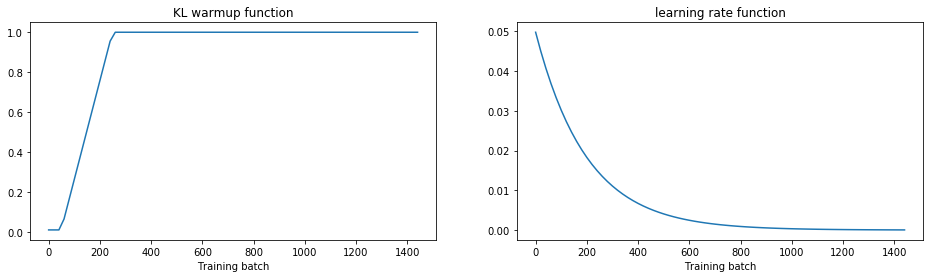

In [13]:
# Plot the warmup function and the learning rate decay function.
plt.figure(figsize=(16,4), facecolor='white')
plt.subplot(1, 2, 1)
x = onp.arange(0, num_batches, print_every)
kl_params = {'kl_warmup_start': kl_warmup_start,
             'kl_warmup_end': kl_warmup_end,
             'kl_min': kl_min,
             'kl_max': kl_max}
kl_warmup_fun = get_kl_warmup_fun(kl_params)
plt.plot(x, [kl_warmup_fun(i) for i in onp.arange(1, num_batches, print_every)]);
plt.title('KL warmup function')
plt.xlabel('Training batch')

plt.subplot(1, 2, 2)
decay_fun = optimizers.exponential_decay(STEP_SIZE, DECAY_STEPS, DECAY_FACTOR)
plt.plot(x, [decay_fun(i) for i in range(1, num_batches, print_every)])
plt.title('learning rate function')
plt.xlabel('Training batch') 

plt.show()

### Collect hyperparams


In [14]:
lfads_hps = {'data_dim' : n_neurons, 'ntimesteps' : n_timesteps,
             'enc_dim' : ENC_DIM, 'con_dim' : CON_DIM, 'var_min' : VAR_MIN,
             'ic_prior_var' : IC_PRIOR_VAR, 'ar_mean' : ar_mean,
             'ar_autocorrelation_tau' : ar_autocorrelation_tau,
             'ar_noise_variance' : ar_noise_variance,
             'ii_dim' : II_DIM, 'gen_dim' : GEN_DIM,
             'factors_dim' : FACTORS_DIM,
             'l2reg' : L2_REG,
             'batch_size' : BATCH_SIZE}

lfads_opt_hps = {'num_batches' : num_batches, 'step_size' : STEP_SIZE,
                 'decay_steps' : DECAY_STEPS, 'decay_factor' : DECAY_FACTOR,
                 'kl_min' : kl_min, 'kl_max' : kl_max, 'kl_warmup_start' : kl_warmup_start,
                 'kl_warmup_end' : kl_warmup_end, 'keep_rate' : keep_rate,
                 'max_grad_norm' : MAX_GRAD_NORM, 'print_every' : print_every,
                 'adam_b1' : 0.9, 'adam_b2' : 0.999, 'adam_eps' : 1e-1}

init_params = lfads.lfads_params(key, lfads_hps)


## Train LFADS


In [15]:
trained_params, opt_details = \
    optimize_lfads(key, init_params, lfads_hps, lfads_opt_hps, X_train, X_valid)


Batches 1-20 in 384.38 sec, Step size: 0.04523, Training loss 3909, Eval loss 3834
Batches 21-40 in 1.62 sec, Step size: 0.04092, Training loss 3486, Eval loss 3664
Batches 41-60 in 1.96 sec, Step size: 0.03701, Training loss 3536, Eval loss 3476
Batches 61-80 in 1.96 sec, Step size: 0.03348, Training loss 3487, Eval loss 3517
Batches 81-100 in 1.96 sec, Step size: 0.03029, Training loss 3646, Eval loss 3535
Batches 101-120 in 1.97 sec, Step size: 0.02740, Training loss 3506, Eval loss 3454
Batches 121-140 in 1.96 sec, Step size: 0.02479, Training loss 3510, Eval loss 3567
Batches 141-160 in 1.92 sec, Step size: 0.02242, Training loss 3466, Eval loss 3638
Batches 161-180 in 1.97 sec, Step size: 0.02028, Training loss 3575, Eval loss 3626
Batches 181-200 in 1.96 sec, Step size: 0.01835, Training loss 3515, Eval loss 3560
Batches 201-220 in 1.97 sec, Step size: 0.01660, Training loss 3698, Eval loss 3516
Batches 221-240 in 1.96 sec, Step size: 0.01501, Training loss 3675, Eval loss 3614


### Plot training details


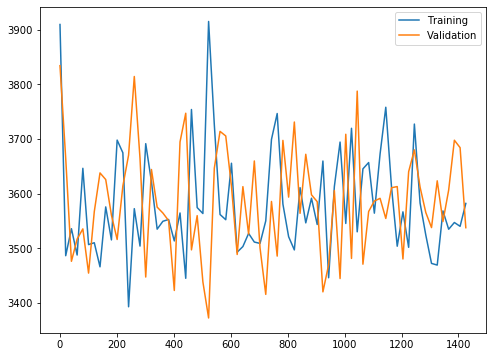

In [16]:
# Plot the training details
x = onp.arange(len(opt_details['tlosses']['total'])) * num_batches / len(opt_details['tlosses']['total'])
plt.figure(figsize=(8, 6), facecolor='white')

plt.plot(x, opt_details['tlosses']['total'], label='Training')
plt.plot(x, opt_details['elosses']['total'], label='Validation')
plt.legend()

plt.show()

## Inspect Model

The first way we are going to inspect the model is to visualize the model state for a given input.
Remember that the latent variables are stochastic. To visualize the inferred factors and rates, we take multiple samples from the distribution parameterized by the latent variable vector, decode each sample, then average inferred factors and rates across samples.

In [17]:
def remove_outliers(A, nstds=3):
    clip = nstds * onp.std(A)
    A_mean = onp.mean(A)
    A_show = onp.where(A < A_mean - clip, A_mean - clip, A)
    return onp.where(A_show > A_mean + clip, A_mean + clip, A_show)

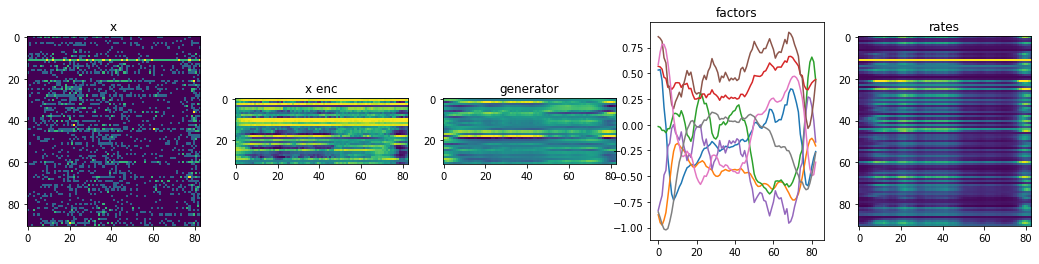

In [24]:
# Plot an example validation trial run through LFADS.

bidx = onp.random.randint(X_valid.shape[0])
key, fkeys = utils.keygen(key, 1)
psa_example = X_valid[bidx,:,:].astype(np.float32)
psa_dict = lfads.posterior_sample_and_average_jit(trained_params, lfads_hps, next(fkeys), psa_example)

f = plt.figure(figsize=(18, 4))

plt.subplot(1, 5, 1)
plt.imshow(psa_example.T)
plt.title('x')

plt.subplot(1, 5, 2)
x_enc = remove_outliers(psa_dict['xenc_t'])
plt.imshow(x_enc.T)
plt.title('x enc')

plt.subplot(1, 5, 3)
gen = remove_outliers(psa_dict['gen_t'])
plt.imshow(gen.T)
plt.title('generator')

plt.subplot(1, 5, 4)
factors = remove_outliers(psa_dict['factor_t'])
# plt.imshow(factors.T)
plt.plot(factors)
plt.title('factors')

plt.subplot(1, 5, 5)
rates = remove_outliers(onp.exp(psa_dict['lograte_t']))
plt.imshow(rates.T)
plt.title('rates')    

plt.show()

The next thing we're going to visualize is the inferred factor activations, colour-coded by trial reaching direction.

/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


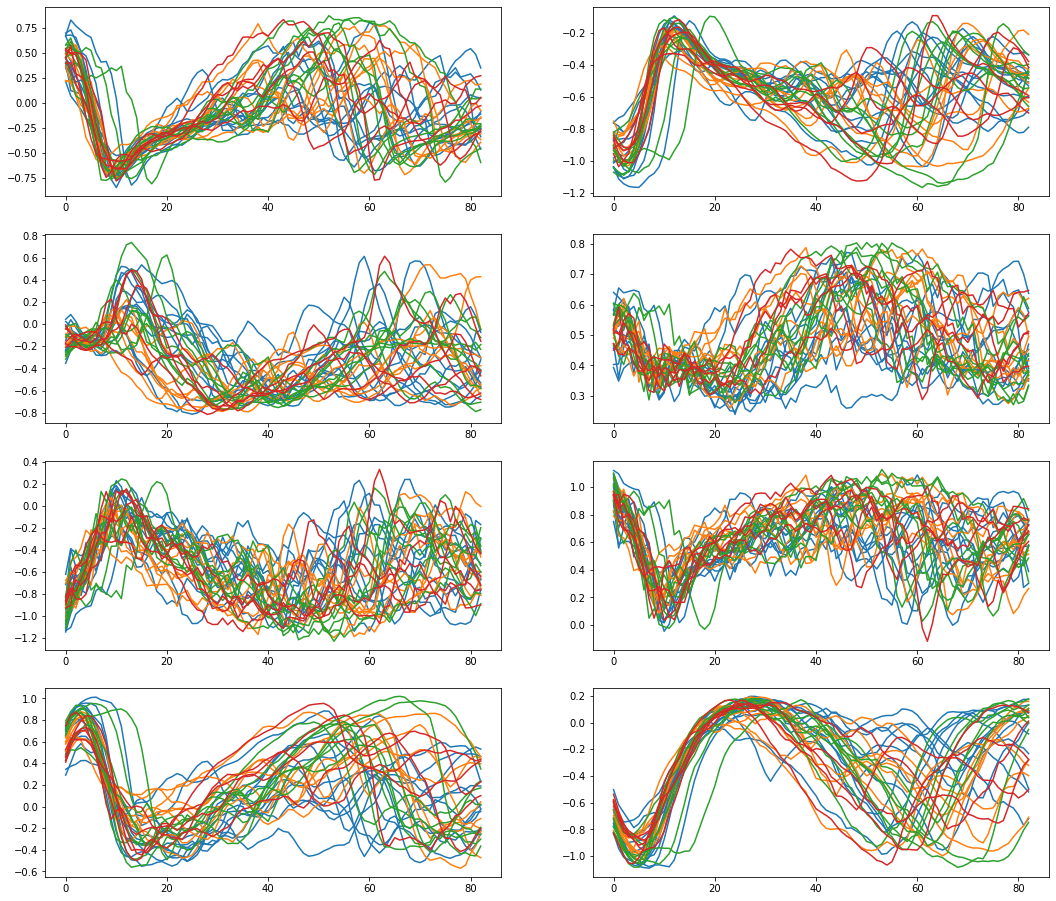

In [21]:
from itertools import cycle

N_ANGLE_BINS = 4

angles = onp.arctan2(targ_valid[:, 1], targ_valid[:, 0])
# Offset by half a bin so that trials that align with ordinates are binned with bin-centres aligning with diagonals.
angles = angles + onp.pi/(N_ANGLE_BINS * 2)
angles = angles % (2*onp.pi)
bin_edges = onp.linspace(0, 2*onp.pi, N_ANGLE_BINS+1)
bin_centres = onp.mean(onp.diff(bin_edges))
bin_id = onp.digitize(angles, bin_edges)

# Create a colour code cycler e.g. 'C0', 'C1', etc.
colour_codes = map('C{}'.format, cycle(range(N_ANGLE_BINS)))

f = plt.figure(figsize=(18, 16))
for bin_ix in range(N_ANGLE_BINS):
    colour_code = next(colour_codes)
    b_trials = bin_id == bin_ix + 1
    psa_examples = X_valid[b_trials,:,:].astype(np.float32)
    psa_examples = psa_examples[::3]
    key, fkeys = utils.keygen(key, psa_examples.shape[0])
    for psa_example in psa_examples:
        psa_dict = lfads.posterior_sample_and_average_jit(trained_params, lfads_hps, next(fkeys), psa_example)
        for fac_ix in range(psa_dict['factor_t'].shape[-1]):
            plt.subplot(4, 2, fac_ix + 1)
            plt.plot(psa_dict['factor_t'][:, fac_ix], color=colour_code)
plt.show()

This result isn't so overwhelming. I don't know about you, but I don't see a difference between colours. There are a couple reasons why we might expect this model to fail.
* I have yet to optimize the hyperparameters
* This version of the model assumes external input even though there was none.
* Trials were grouped by movement direction but there's likely a big difference between rightward movements between adjacent targets in the bottom right and rightward movements from the top-left to top-right target.

I reimplemented LFADS in JAX without inferred input. This implementation also uses slightly easier to follow code and is heavily commented (though more comments coming), so it might be a good reference to help understand LFADS. [See here](https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/indl/lfads/lfads.py). However, the model took twice as long to compile and it ran slower.

Refer to the LFADS paper for better examples of what this type of analysis is capable of.

## Save the model


In [22]:
network_path = str(datadir / 'lfads_model.npz')
# Note we are just using numpy save instead of h5 because the LFADS parameter 
# is nested dictionaries, something I couldn't get h5 to save down easily.
print("Saving parameters: ", network_path)
onp.savez(network_path, trained_params)


Saving parameters:  /media/chad/STORE/Tools/Neurophys/IntracranialNeurophysDL/data/joeyo/lfads_model.npz
